In [64]:
import cirq
import qsimcirq
import numpy as np
import qiskit
import qiskit_ibm_runtime
from qiskit_aer import AerSimulator

from qiskit.visualization import plot_histogram
from encoded.dj import dj, dj_repetition
from encoded.LST import int_to_binary

## Computer parameters

In [65]:
# Computer and qubits to use.
# Option 1: Use saved noise characteristics.
computer = qiskit_ibm_runtime.fake_provider.FakeKyiv()
#computer = AerSimulator()  # Noiseless simulator - use this for a sanity check to see all computed expectation
layout = {
    1 : [63, 64],
    3 : [65, 66, 67, 73, 84, 85],
    5 : [64, 65, 66, 67, 72,81, 82, 83, 84, 85],
    7 : [61, 62, 63, 64, 65, 66, 67, 72, 73, 81, 82, 83, 84, 85],
    #7 : [117,122,123, 124, 125, 126, 127,136,137,143,144,145,146,147]
}

## Oracle definition

In [66]:
total_qubits = 2
# Random case
# oracleType, oracleValue = np.random.randint(2), np.random.randint(2)
# if oracleType == 1:
#     oracleValue = np.random.randint(1, 2**(total_qubits-1))

# Fixed case
oracleType, oracleValue = 1, 2**(total_qubits-1)-1
oracleType,oracleValue

(1, 1)

## Analog version

In [67]:


n_shots = 500_000
qreg = cirq.LineQubit.range(total_qubits)
circuit = dj(qreg,oracleType,oracleValue)
circuit.append(cirq.measure(qreg[:total_qubits-1], key="m"))
circuit = qiskit.QuantumCircuit.from_qasm_str(circuit.to_qasm())


compiled_raw = qiskit.transpile(
    circuit, 
    backend=computer,
    initial_layout=layout[1],  
    routing_method="sabre",
    optimization_level=0,
)

job = computer.run(compiled_raw, shots=n_shots)
counts = job.result().get_counts()


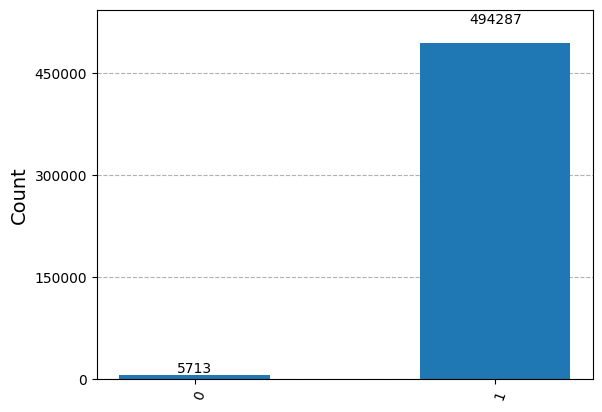

In [68]:
threshold = int(0.001 * n_shots) 
filteredAnswer = {k: v for k,v in counts.items() if v >= threshold}
removedCounts = np.sum([ v for k,v in counts.items() if v < threshold ]) 
plot_histogram(filteredAnswer)

In [69]:
if oracleType==1:
    print("Total fidelity F = ",counts[int_to_binary(total_qubits-1,oracleValue)]/n_shots*100,"%")
else:
    print("Total fidelity F = ",counts["0"*(total_qubits-1)]/n_shots*100,"%")

Total fidelity F =  98.8574 %


## Encoding the repetition code (k = 2)

In [70]:
oracleType, oracleValue = 1, 2**(total_qubits-1)-1
k = 2 
n_encoding = 5

logical_1_codeword = ["1"*n_encoding*(k-1)]
logical_0_codeword = ["0"*n_encoding*(k-1)]

qreg = cirq.LineQubit.range(n_encoding*k)
circuit= dj_repetition(qreg,n_encoding,oracleType,oracleValue)

circuit.append(cirq.measure(qreg[:n_encoding*(k-1)], key="m"))
circuit = qiskit.QuantumCircuit.from_qasm_str(circuit.to_qasm())


compiled_raw = qiskit.transpile(
    circuit, 
    backend=computer,
    initial_layout=layout[n_encoding],
    routing_method="sabre", 
    optimization_level=3,
)
compiled_raw.count_ops()


OrderedDict([('rz', 273), ('sx', 166), ('ecr', 83), ('x', 12), ('measure', 5)])

In [76]:

circuit.draw()


┌───┐                                                                 »
  q_0: ┤ H ├──■──────────────■────────────────────────────────────────────■──»
       └───┘┌─┴─┐            │                                          ┌─┴─┐»
  q_1: ─────┤ X ├──■─────────┼─────────■─────────────────────────────■──┤ X ├»
            └───┘┌─┴─┐       │         │                           ┌─┴─┐└───┘»
  q_2: ──────────┤ X ├──■────┼─────────┼────■───────────────────■──┤ X ├─────»
                 └───┘┌─┴─┐  │         │    │                 ┌─┴─┐└───┘     »
  q_3: ───────────────┤ X ├──┼────■────┼────┼────■─────────■──┤ X ├──────────»
                      └───┘  │  ┌─┴─┐  │    │    │       ┌─┴─┐└───┘          »
  q_4: ──────────────────────┼──┤ X ├──┼────┼────┼────■──┤ X ├───────────────»
       ┌───┐┌───┐          ┌─┴─┐└───┘  │    │    │    │  └───┘               »
  q_5: ┤ X ├┤ H ├──■───────┤ X ├───────┼────┼────┼────┼──────────────────────»
       └───┘└───┘┌─┴─┐     └───┘     ┌─┴─┐  │    │    │                      »
  q_6: ──────────┤ X ├──■────────────┤ X ├──┼────┼────┼──────────────────────»
                 └───┘┌─┴─┐          └───┘┌─┴─┐  │    │                      »
  q_7: ───────────────┤ X ├──■────────────┤ X ├──┼────┼──────────────────────»
                      └───┘┌─┴─┐          └───┘┌─┴─┐  │                      »
  q_8: ────────────────────┤ X ├──■────────────┤ X ├──┼──────────────────────»
                           └───┘┌─┴─┐          └───┘┌─┴─┐                    »
  q_9: ─────────────────────────┤ X ├───────────────┤ X ├────────────────────»
                                └───┘               └───┘                    »
m_m: 5/══════════════════════════════════════════════════════════════════════»
                                                                             »
«       ┌───┐          ┌─┐                      
«  q_0: ┤ H ├──■───────┤M├──────────────────────
«       └───┘┌─┴─┐     └╥┘     ┌─┐              
«  q_1: ─────┤ X ├──■───╫──────┤M├──────────────
«            └───┘┌─┴─┐ ║      └╥┘     ┌─┐      
«  q_2: ──────────┤ X ├─╫───■───╫──────┤M├──────
«                 └───┘ ║ ┌─┴─┐ ║      └╥┘┌─┐   
«  q_3: ────────────────╫─┤ X ├─╫───■───╫─┤M├───
«                       ║ └───┘ ║ ┌─┴─┐ ║ └╥┘┌─┐
«  q_4: ────────────────╫───────╫─┤ X ├─╫──╫─┤M├
«                       ║       ║ └───┘ ║  ║ └╥┘
«  q_5: ────────────────╫───────╫───────╫──╫──╫─
«                       ║       ║       ║  ║  ║ 
«  q_6: ────────────────╫───────╫───────╫──╫──╫─
«                       ║       ║       ║  ║  ║ 
«  q_7: ────────────────╫───────╫───────╫──╫──╫─
«                       ║       ║       ║  ║  ║ 
«  q_8: ────────────────╫───────╫───────╫──╫──╫─
«                       ║       ║       ║  ║  ║ 
«  q_9: ────────────────╫───────╫───────╫──╫──╫─
«                       ║       ║       ║  ║  ║ 
«m_m: 5/════════════════╩═══════╩═══════╩══╩══╩═
«                       0       1       2  3  4

In [15]:
job = computer.run(compiled_raw, shots=n_shots)
counts = job.result().get_counts()

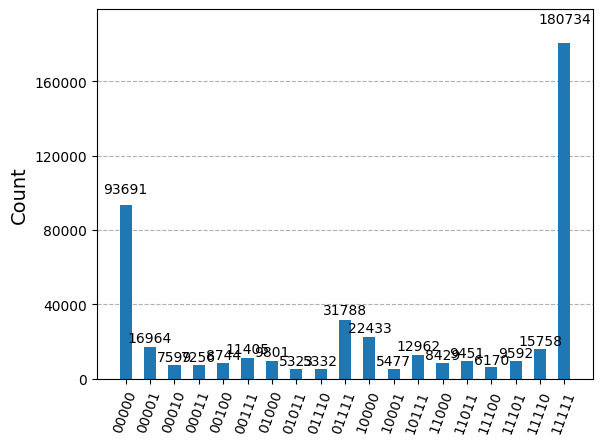

In [16]:
threshold = int(0.01 * n_shots)
filteredAnswer = {k: v for k,v in counts.items() if v >= threshold} 
removedCounts = np.sum([ v for k,v in counts.items() if v < threshold ]) 
plot_histogram(filteredAnswer)

### Using the encoding to take into account only the logical errors

In [17]:
counts_logical_1 = 0
for e in logical_1_codeword:
    counts_logical_1 += counts[e]
counts_logical_0 = 0
for e in logical_0_codeword:
    counts_logical_0 += counts[e]

if oracleType==1 and oracleValue ==1:
    print("Total fidelity F = ",counts_logical_1/(counts_logical_1+counts_logical_0)*100,"%")
else:
    print("Total fidelity F = ",counts_logical_0/(counts_logical_1+counts_logical_0)*100,"%")

Total fidelity F =  65.8591600619477 %


## Using custom backend
Goal: take the calibration data from IBMQ (newest)

In [13]:
import os
from qiskit_ibm_runtime.fake_provider import fake_backend


class FakeKyiv2025(fake_backend.FakeBackendV2):
    """A fake 127 qubit backend configuration updated 2025."""

    dirname = os.path.dirname("/Users/yanislefur/Documents/encoded/experiments/repetition/Deutsh-Jozsa/config")  # 
    conf_filename = "/Users/yanislefur/Documents/encoded/experiments/repetition/Deutsh-Jozsa/config/conf_kyiv.json" 
    props_filename = "/Users/yanislefur/Documents/encoded/experiments/repetition/Deutsh-Jozsa/config/props_kyiv.json" 
    defs_filename = "/Users/yanislefur/Documents/encoded/experiments/repetition/Deutsh-Jozsa/config/defs_kyiv.json" 
    backend_name = "fake_kyiv2025" 


In [14]:
computer = FakeKyiv2025()

In [15]:
oracleType, oracleValue = 1, 2**(total_qubits-1)-1
k = 2 
n_encoding = 3

logical_1_codeword = ["1"*n_encoding*(k-1)]
logical_0_codeword = ["0"*n_encoding*(k-1)]

qreg = cirq.LineQubit.range(n_encoding*k)
circuit= dj_repetition(qreg,n_encoding,oracleType,oracleValue)

circuit.append(cirq.measure(qreg[:n_encoding*(k-1)], key="m"))
circuit = qiskit.QuantumCircuit.from_qasm_str(circuit.to_qasm())


compiled_raw = qiskit.transpile(
    circuit, 
    backend=computer,
    initial_layout=layout[n_encoding],
    routing_method="sabre", 
    optimization_level=3,
)
compiled_raw.count_ops()


OrderedDict([('rz', 98), ('sx', 59), ('ecr', 25), ('x', 4), ('measure', 3)])

In [16]:
job = computer.run(compiled_raw, shots=n_shots)
counts = job.result().get_counts()

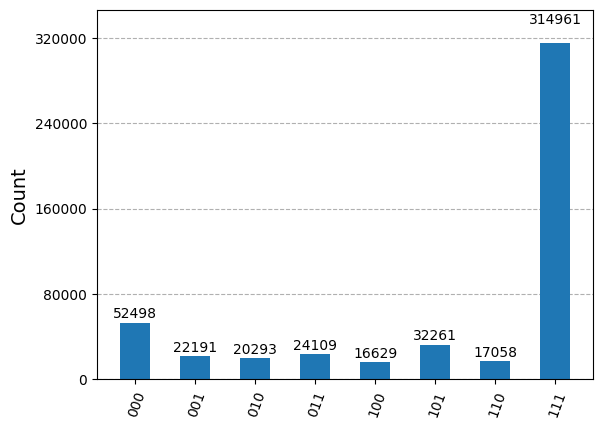

In [17]:
threshold = int(0.01 * n_shots)
filteredAnswer = {k: v for k,v in counts.items() if v >= threshold} 
removedCounts = np.sum([ v for k,v in counts.items() if v < threshold ]) 
plot_histogram(filteredAnswer)

In [18]:
counts_logical_1 = 0
for e in logical_1_codeword:
    counts_logical_1 += counts[e]
counts_logical_0 = 0
for e in logical_0_codeword:
    counts_logical_0 += counts[e]

if oracleType==1 and oracleValue ==1:
    print("Total fidelity F = ",counts_logical_1/(counts_logical_1+counts_logical_0)*100,"%")
else:
    print("Total fidelity F = ",counts_logical_0/(counts_logical_1+counts_logical_0)*100,"%")

Total fidelity F =  85.71323603449636 %


In [22]:
import json 
def _load_json(filename: str) -> dict:
        with open(  # pylint: disable=unspecified-encoding
            os.path.join( filename)
        ) as f_json:
            the_json = json.load(f_json)
        return the_json

In [30]:
import qiskit_ibm_runtime
props_dict = _load_json("/Users/yanislefur/Documents/encoded/experiments/repetition/Deutsh-Jozsa/config/props_kyiv.json")  # type: ignore
props_dict.keys()

dict_keys(['backend_name', 'backend_version', 'last_update_date', 'qubits', 'gates', 'general', 'general_qlists'])

In [108]:
QPU_qubits = 127
props_dict["gates"][QPU_qubits*4:QPU_qubits*5]#["parameters"]#[0]["value"]

[{'qubits': [0, 1],
  'gate': 'ecr',
  'parameters': [{'date': '2024-02-28T04:00:06-05:00',
    'name': 'gate_error',
    'unit': '',
    'value': 0.07886322764453232},
   {'date': '2024-02-25T08:25:01-05:00',
    'name': 'gate_length',
    'unit': 'ns',
    'value': 561.7777777777777}],
  'name': 'ecr0_1'},
 {'qubits': [4, 3],
  'gate': 'ecr',
  'parameters': [{'date': '2024-02-28T04:00:06-05:00',
    'name': 'gate_error',
    'unit': '',
    'value': 0.007195804443850928},
   {'date': '2024-02-25T08:25:01-05:00',
    'name': 'gate_length',
    'unit': 'ns',
    'value': 561.7777777777777}],
  'name': 'ecr4_3'},
 {'qubits': [7, 8],
  'gate': 'ecr',
  'parameters': [{'date': '2024-02-28T04:00:06-05:00',
    'name': 'gate_error',
    'unit': '',
    'value': 0.007673094470966341},
   {'date': '2024-02-25T08:25:01-05:00',
    'name': 'gate_length',
    'unit': 'ns',
    'value': 561.7777777777777}],
  'name': 'ecr7_8'},
 {'qubits': [10, 11],
  'gate': 'ecr',
  'parameters': [{'date': '20

In [85]:
import pandas as pd
df_kyiv = pd.read_csv("ibm_kyiv_calibrations_2025-02-26T16_02_56Z.csv")
df_kyiv

,Qubit,T1 (us),T2 (us),Frequency (GHz),Anharmonicity (GHz),Readout assignment error,Prob meas0 prep1,Prob meas1 prep0,Readout length (ns),ID error,Z-axis rotation (rz) error,√x (sx) error,Pauli-X error,ECR error,Gate time (ns),Operational
0,0,398.988451,400.331927,4.655635,-0.311063,0.007080,0.006348,0.007812,1244.444444,0.000105,0,0.000105,0.000105,0_14:0.006280559683150666;0_1:0.00394677818955...,0_14:561.7777777777777;0_1:561.7777777777777,True
1,1,414.996442,180.338532,4.534964,-0.313030,0.009521,0.007812,0.011230,1244.444444,0.000098,0,0.000098,0.000098,1_2:0.013470305507750857,1_2:561.7777777777777,True
2,2,261.724913,112.353301,4.680132,-0.309256,0.011963,0.013184,0.010742,1244.444444,0.000599,0,0.000599,0.000599,2_3:0.01375449643358212,2_3:583.1111111111111,True
3,3,450.800935,142.134682,4.606647,-0.251358,0.008545,0.012207,0.004883,1244.444444,0.000107,0,0.000107,0.000107,NaN,NaN,True
4,4,541.819263,109.191898,4.462296,-0.255079,0.082275,0.063965,0.100586,1244.444444,0.000640,0,0.000640,0.000640,4_15:0.010206582251858276;4_3:0.00779466986379...,4_15:583.1111111111111;4_3:561.7777777777777,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,122,265.789805,127.252338,4.688044,-0.308443,0.007812,0.006836,0.008789,1244.444444,0.000139,0,0.000139,0.000139,122_121:1;122_123:0.007676549485707118,122_121:583.1111111111111;122_123:561.77777777...,True
123,123,195.112221,388.287776,4.730559,-0.307833,0.111328,0.105957,0.116699,1244.444444,0.000279,0,0.000279,0.000279,123_124:0.013305527153374686,123_124:583.1111111111111,True
124,124,239.557384,65.931280,4.634884,-0.308506,0.010498,0.013184,0.007812,1244.444444,0.000384,0,0.000384,0.000384,NaN,NaN,True
125,125,316.311966,323.629120,4.737112,-0.307154,0.010254,0.011719,0.008789,1244.444444,0.001101,0,0.001101,0.001101,125_124:0.015296874544464434;125_126:0.0155069...,125_124:561.7777777777777;125_126:583.11111111...,True


In [99]:
data_test  = list(df_kyiv["ECR error "].dropna())

dictionary = {}

for entry in data_test:
    pairs = entry.split(';')  # Split multiple key-value pairs in a string
    for pair in pairs:
        key, value = pair.split(':')  # Separate the key from the value
        key = list(map(int, key.split('_')))  # Transform key into a list of integers
        dictionary[tuple(key)] = float(value)

print(dictionary)

{(0, 14): 0.006280559683150666, (0, 1): 0.003946778189551858, (1, 2): 0.013470305507750857, (2, 3): 0.01375449643358212, (4, 15): 0.010206582251858276, (4, 3): 0.0077946698637935685, (5, 4): 0.0075016407337013535, (6, 5): 0.00560827945517417, (7, 6): 0.010697046317997672, (7, 8): 0.00946841170154289, (8, 9): 0.03297314977095922, (10, 9): 0.008519377752825186, (10, 11): 0.00845195520641523, (11, 12): 0.005015876928476826, (13, 12): 0.0057901698185193196, (14, 18): 0.004930128169991277, (16, 8): 0.010688850772953284, (17, 12): 0.012281171681152392, (17, 30): 0.09540252160757023, (19, 18): 0.0057446447457960015, (20, 19): 0.011693463123615133, (21, 20): 0.012024450705782841, (21, 22): 0.013186785130199774, (22, 23): 0.010820059034099272, (22, 15): 0.017531299060357275, (23, 24): 0.043229200554619096, (24, 25): 0.014907424025590144, (26, 16): 0.011217857887329485, (26, 25): 0.010469657145124267, (26, 27): 0.012498376470469585, (28, 27): 0.013509022388923653, (29, 28): 0.006013337210017566,

In [133]:
props_dict["gates"][QPU_qubits*4+1]["qubits"]
dictionary[tuple(props_dict["gates"][QPU_qubits*4+1]["qubits"])]

0.0077946698637935685

In [129]:
cmap = FakeKyiv2025.coupling_map.__dict__

AttributeError: 'property' object has no attribute '__dict__'

In [130]:
FakeKyiv2025.__dict__

mappingproxy({'__module__': '__main__',
              '__doc__': 'A fake 127 qubit backend configuration updated 2025.',
              'dirname': '/Users/yanislefur/Documents/encoded/experiments/repetition/Deutsh-Jozsa',
              'conf_filename': '/Users/yanislefur/Documents/encoded/experiments/repetition/Deutsh-Jozsa/config/conf_kyiv.json',
              'props_filename': '/Users/yanislefur/Documents/encoded/experiments/repetition/Deutsh-Jozsa/config/props_kyiv.json',
              'defs_filename': '/Users/yanislefur/Documents/encoded/experiments/repetition/Deutsh-Jozsa/config/defs_kyiv.json',
              'backend_name': 'fake_kyiv2025',
              '__abstractmethods__': frozenset(),
              '_abc_impl': <_abc._abc_data at 0x134fb1e40>})